# ACNets: Connectivity Classifier

This notebook fits a binary classifier to predict participant's group, AVGP or NVGP, using Cognitive Control network connectivity matrices. As input, it receives upper-triangular connectivity matrices for each participant. Results are evaluated using 5-fold cross-validated f1 on the train set.

## Setup

In [45]:

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection, dummy
from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier  # incompatible with umap's scipy

sns.set(style='dark')

from umap import UMAP

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-02-11T11:09:30.454335+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

seaborn   : 0.11.2
xarray    : 0.21.1
numpy     : 1.21.5
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
sklearn   : 1.0.2
matplotlib: 3.5.1
pandas    : 1.4.0
plotly    : 5.5.0



### Load the data

In [46]:
DATASET = xr.open_dataset('data/julia2018_resting/connectivity_dosenbach2007.nc').load()

## Input/output data

In [47]:
# 1. input (connectivities)
X = np.array(
  [subj_conn[np.triu_indices_from(subj_conn, k=1)] 
   for subj_conn in DATASET['tangent_connectivity'].values]
  )

# 2. classifier output (AVGP or NVGP)
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(DATASET['group'])

# 3. behavioral outputs (inverse efficiency scores in millis)
y_beh = DATASET['inverse_efficiency_score_ms'].values

# 4. remove subjects with missing connectivity and behavioral data
valid_subjects_mask = ~np.isnan(y_beh)
X = X[valid_subjects_mask]
y = y[valid_subjects_mask]
y_beh = y_beh[valid_subjects_mask]

## Test/train split

In [68]:
# 3. test/train split
X_train, X_test, y_train, y_test, y_beh_train, y_beh_test = model_selection.train_test_split(
  X, y, y_beh,
  test_size=.25, shuffle=True, stratify=y,
  # random_state=42,
  )

## Classification pipeline

In [65]:
# custom model
from sklearn.base import BaseEstimator, ClassifierMixin

class MixedReducerModel(ClassifierMixin):
    def __init__(self, select_k=10, n_neighbors=15, n_components=3):
        self.selector = feature_selection.SelectKBest(k=select_k)
        self.reducer = UMAP(n_neighbors=n_neighbors, n_components=n_components) 
        self.model = ensemble.GradientBoostingClassifier()  
    def fit(self, X, y):
        _y_beh = y[:,0]  #  behavioral
        _y = y[:,1]      # classification output
        X_selected = self.selector.fit_transform(X, _y)
        X_reduced = self.reducer.fit_transform(X_selected, _y_beh)
        self.model.fit(X_reduced, _y)
        return self
    def transform(self, X):
        X_selected = self.selector.transform(X)
        X_reduced = self.reducer.transform(X_selected)
        y = self.model.predict(X_reduced)
        return y
    def predict(self, X):
        X_selected = self.selector.transform(X)
        X_reduced = self.reducer.transform(X_selected)
        y = self.model.predict(X_reduced)
        return y

# DEBUG
# pipeline.fit(X_train, np.vstack([y_beh_train, y_train]).T)
# score = pipeline.score(X_test, y_test)


In [69]:
# ALT1: boosting
model = ensemble.AdaBoostClassifier()

# ALT2: chance level
# model = dummy.DummyClassifier(strategy='uniform')

# ALT3: multi-output
# model = multioutput.MultiOutputClassifier(ensemble.GradientBoostingClassifier())


pipeline = Pipeline([
    ('zerovar', feature_selection.VarianceThreshold()),
    ('select', feature_selection.SelectKBest()),
    # ('standard_scaler', preprocessing.StandardScaler()), 
    # DEBUG ('model', MixedReducerModel()),
    # ('reducer', UMAP(n_components=3)), 
    ('reducer', decomposition.PCA()),
    # ('reducer', cross_decomposition.PLSCanonical()),    
    ('model', model)
], verbose=True)


param_grid = {
    # 'zerovar__threshold': [0],
    # 'select__k': np.linspace(1, X.shape[1], 10, dtype='int'),
    # 'reducer__n_neighbors': [1, 2, 3, 4, 5, 10],  # UMAP
    # 'reducer__n_components': [2,3,5],  # UMAP
    'reducer__n_components': range(1,100),  # PCA
    # 'model__n_estimators': [10, 100, 1000],  # XGBClassifier, GradientBoostingClassifier
    # 'model__estimator__n_estimators': [10, 100],  # MultiOutputClassifier
}

grid = model_selection.GridSearchCV(
    pipeline, param_grid, cv=5,
    scoring='roc_auc',
    # scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], refit='accuracy',
    n_jobs=1, verbose=3
)

grid.fit(X_train, y_train)
score = grid.score(X_test, y_test)

# report scores
clear_output(wait=True)

print(f'Test set score (roc_auc): {score:.2f}')

Test set score (roc_auc): 0.56


## Model performance
Below is the confusion matrix of the classifier on the train and test sets.

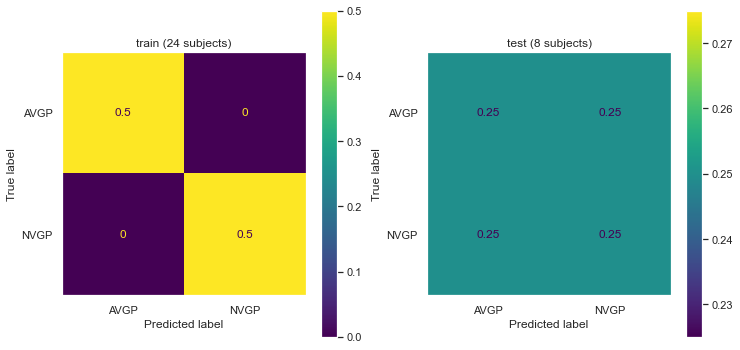

In [70]:
# plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# train set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X_train, y_train,
  normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[0],
  )

# test set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X_test, y_test,
  normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[1],
  )

# set titles
axes[0].set(title=f'train ({len(y_train)} subjects)')
axes[1].set(title=f'test ({len(y_test)} subjects)')

plt.show()